## Workloads with Dask Delayed

In [1]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:35495 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 15.64 GiB


In [2]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

In [3]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 29.6 ms, sys: 6.53 ms, total: 36.1 ms
Wall time: 2.05 s


3

In [4]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [5]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 270 µs, sys: 32 µs, total: 302 µs
Wall time: 262 µs


Delayed('add-1f2a6ed6-8eca-42af-9d80-5e36e7a5f6f5')

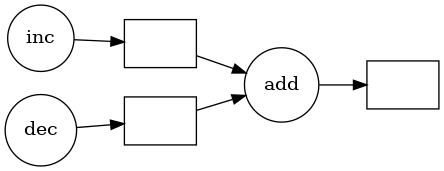

In [6]:
z.visualize(rankdir='LR')

In [7]:
z.compute()

3

In [8]:
%%time
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

zs = dask.persist(*zs)  # trigger computation in the background

CPU times: user 39.4 ms, sys: 13.1 ms, total: 52.5 ms
Wall time: 44.4 ms


In [9]:
for i in range(10):
    client.cluster.scale(n=4)

In [10]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

([65536],)

## Workloads with Futures

In [11]:
def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

In [12]:
inc(1)

2

In [13]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: pending, key: inc-d60f35e3c4e7927e79bba1f842ac83c8>

In [14]:
future

<Future: pending, key: inc-d60f35e3c4e7927e79bba1f842ac83c8>

In [15]:
future.result()

2

### Chain dependencies

You can submit tasks on other futures. This will create a dependency between the inputs and outputs. Dask will track the execution of all tasks, ensuring that downstream tasks are run at the proper time and place and with the proper data.

In [16]:
def inc(x):
    time.sleep(random.random())
    return x + 1

def double(x):
    time.sleep(random.random())
    return 2 * x

def add(x, y):
    time.sleep(random.random())
    return x + y

In [17]:
x = client.submit(inc, 1)
y = client.submit(double, 2)
z = client.submit(add, x, y)
z

<Future: pending, key: add-20de840b7f47d2ce968a9fce2421a389>

In [18]:
z.result()

6

In [19]:
%%time
zs = []
for i in range(256):
    x = client.submit(inc, i)     # x = inc(i)
    y = client.submit(double, x)  # y = inc(x)
    z = client.submit(add, x, y)  # z = inc(y)
    zs.append(z)

total = client.submit(sum, zs)

CPU times: user 115 ms, sys: 19.1 ms, total: 134 ms
Wall time: 110 ms


### Custom computation: Tree summation

In [20]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        future = client.submit(add, L[i], L[i + 1])  # add neighbors
        new_L.append(future)
    L = new_L                                   # swap old list for new

### Building a computation dynamically

In [21]:
del future, L, new_L, total  # clear out some old work

In [22]:
from dask.distributed import as_completed

zs = client.map(inc, zs)
seq = as_completed(zs)

while seq.count() > 2:  # at least two futures left
    a = next(seq)
    b = next(seq)
    new = client.submit(add, a, b)  # add them together
    seq.add(new)                    # add new future back into loop

# Parallel

In [23]:
from dask.distributed import Client, progress
# client = Client(threads_per_worker=4, n_workers=1)
# client

In [24]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [25]:
%time costly_simulation([1, 2, 3, 4])

CPU times: user 33 ms, sys: 6.95 ms, total: 40 ms
Wall time: 902 ms


10

In [26]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

,param_a,param_b,param_c,param_d
0,0.751227,0.562740,0.490942,0.130720
1,0.032335,0.775270,0.291482,0.606577
2,0.404475,0.919442,0.976609,0.467808
3,0.449575,0.910223,0.237756,0.635727
4,0.539654,0.535271,0.272263,0.397733


In [27]:
%%time
results = []
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

CPU times: user 180 ms, sys: 31.5 ms, total: 211 ms
Wall time: 5.95 s


In [28]:
results

[1.9356289580908843,
 1.705664085220925,
 2.768333824670696,
 2.2332807849715017,
 1.7449213196024909,
 2.3705786211396207,
 2.368094250516204,
 1.5155137943151782,
 1.4009164809589416,
 1.7777907253515033]

### Dask Delayed

In [29]:
%%time
import dask
lazy_results = []

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 0 ns, sys: 1.28 ms, total: 1.28 ms
Wall time: 882 µs


In [30]:
lazy_results[0]

Delayed('costly_simulation-ddd42869-b3a7-4fe6-bf36-91edfa101cba')

## Run in parallel

The lazy_results list contains information about ten calls to costly_simulation that have not yet been run. Call .compute() when you want your result as normal Python objects.

If you started Client() above then you may want to watch the status page during computation.

In [31]:
%time dask.compute(*lazy_results)

CPU times: user 67.8 ms, sys: 7.59 ms, total: 75.4 ms
Wall time: 1 s


(1.9356289580908843,
 1.705664085220925,
 2.768333824670696,
 2.2332807849715017,
 1.7449213196024909,
 2.3705786211396207,
 2.368094250516204,
 1.5155137943151782,
 1.4009164809589416,
 1.7777907253515033)

In [32]:
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

In [33]:
for i in range(10):
    client.cluster.scale(n=4)

In [34]:
results = dask.compute(*futures)
results[:5]

(1.9356289580908843,
 1.705664085220925,
 2.768333824670696,
 2.2332807849715017,
 1.7449213196024909)

### Doing some analysis on the results

In [35]:
output = input_params.copy()
output['result'] = pd.Series(results, index=output.index)
output.sample(5)

,param_a,param_b,param_c,param_d,result
17,0.860304,0.543844,0.388798,0.796115,2.589060
30,0.731443,0.128975,0.028279,0.470157,1.358853
39,0.163285,0.287639,0.821721,0.136526,1.409171
437,0.413677,0.506460,0.136723,0.727862,1.784722
116,0.923151,0.650476,0.838569,0.727056,3.139252


<AxesSubplot:>

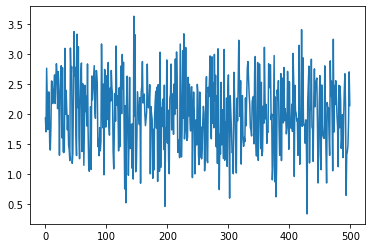

In [36]:
%matplotlib inline
output['result'].plot()

In [37]:
output['result'].mean()

2.0124424032198664

In [38]:
filtered_output = output[output['result'] > 2]
print(len(filtered_output))
# filtered_output.to_csv('/tmp/simulation_result.csv')

255


### Handling very large computation with bags

In [39]:
import dask.bag as db
b = db.from_sequence(list(input_params.values), npartitions=100)
b = b.map(costly_simulation)

In [40]:
%time results_bag = b.compute()

CPU times: user 1e+03 ms, sys: 138 ms, total: 1.14 s
Wall time: 17.2 s


In [41]:
np.all(results) == np.all(results_bag)

True